### Sarcasm Detection                                                                 

                                                                                         


## Get Required Files from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Import required modules required for modelling.

In [4]:
from  wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.metrics import confusion_matrix
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab Notebooks/'

### Reading and Exploring Data


In [6]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [7]:
import pandas as pd
data = pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Drop `article_link` from dataset.


In [8]:
data.drop('article_link',inplace=True,axis=1)

In [10]:
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [8]:
data.shape

(26709, 2)

## Get the Length of each line and find the maximum length


In [9]:
data['wordCount'] = data['headline'].apply(lambda x : len(x.split(" ")))
data['wordCount'].value_counts().max()

3484

## Count of words 

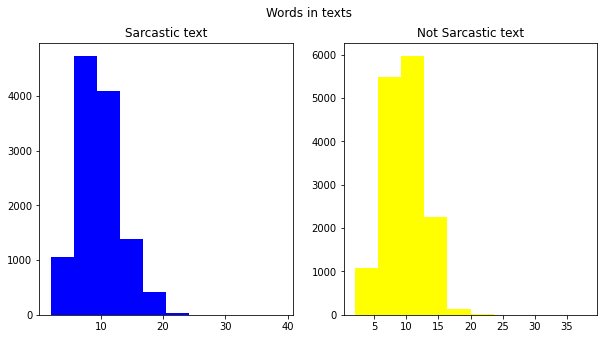

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=data[data['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='blue')
ax1.set_title('Sarcastic text')
text_len=data[data['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='yellow')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

##Word Cloud

Text(0.5, 1.0, 'Word Cloud for Not Sarcastic headlines')

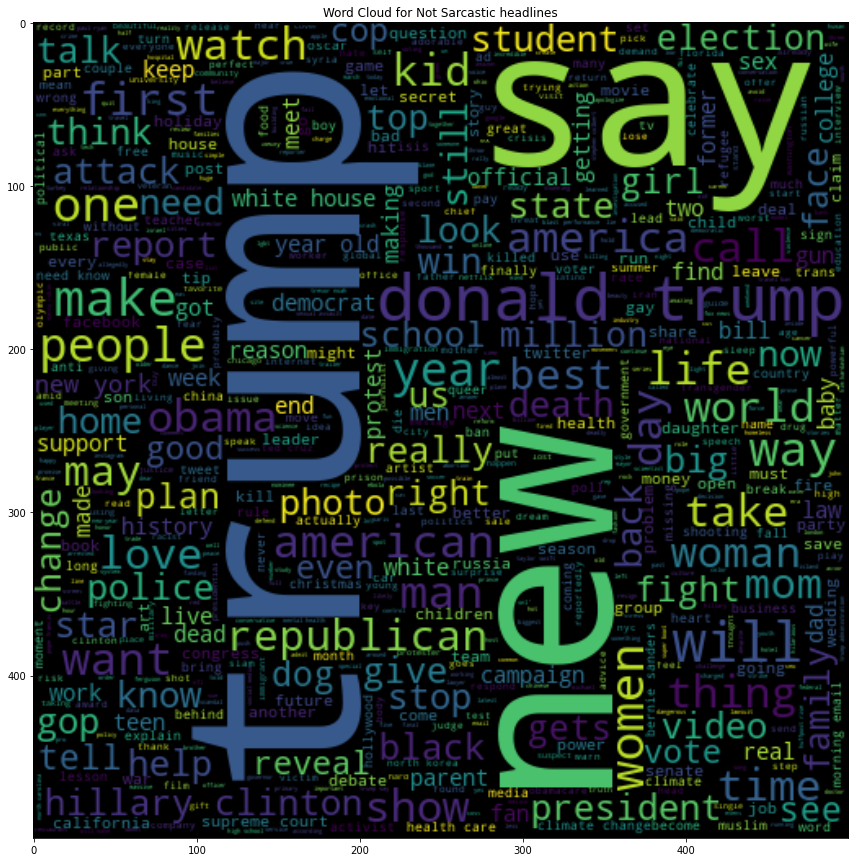

In [31]:
plt.figure(figsize = (20,15)) 
wc = WordCloud(max_words = 2000 , width = 500 , height = 500).generate(" ".join(data[data.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Word Cloud for Not Sarcastic headlines")

Text(0.5, 1.0, 'Word Cloud for Sarcastic headlines')

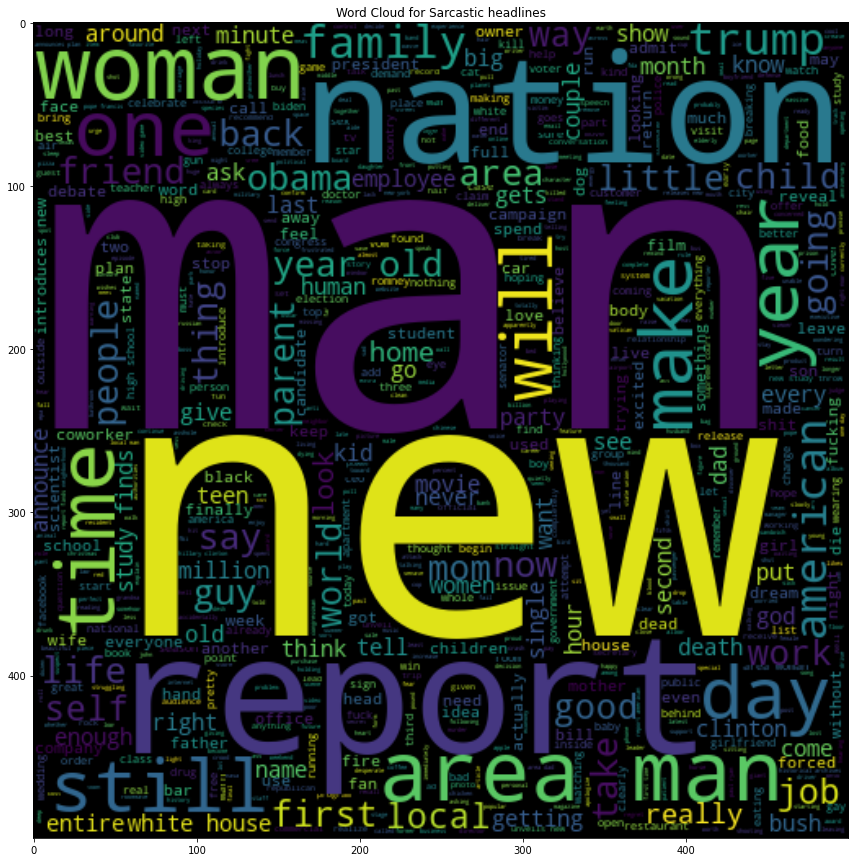

In [32]:
plt.figure(figsize = (20,15)) 
wc = WordCloud(max_words = 2000 , width = 500 , height = 500).generate(" ".join(data[data.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Word Cloud for Sarcastic headlines")

Text(0.5, 1.0, 'Count for each category')

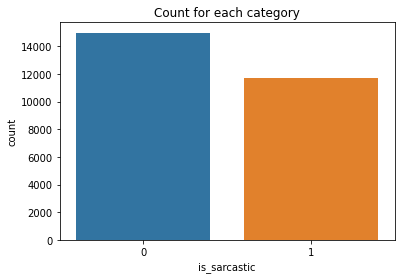

In [8]:
sns.countplot(data['is_sarcastic'])
plt.title("Count for each category")

In [63]:
# Most Frequent words in data
from collections import Counter
words = Counter(" ".join(data["headline"]).split()).most_common(50)
words

[('to', 8206),
 ('of', 5593),
 ('the', 5177),
 ('in', 4170),
 ('for', 3297),
 ('a', 2961),
 ('on', 2371),
 ('and', 1885),
 ('with', 1797),
 ('is', 1666),
 ('new', 1485),
 ('man', 1229),
 ('from', 1221),
 ('at', 1189),
 ('trump', 1157),
 ('about', 1051),
 ('you', 914),
 ('by', 885),
 ('this', 882),
 ('after', 838),
 ('be', 812),
 ('how', 802),
 ('out', 773),
 ('as', 770),
 ('that', 753),
 ('up', 731),
 ('it', 723),
 ('not', 699),
 ('your', 648),
 ('are', 648),
 ('his', 630),
 ('what', 613),
 ('he', 578),
 ('just', 570),
 ('who', 564),
 ('has', 559),
 ('will', 551),
 ('more', 531),
 ('all', 524),
 ('into', 513),
 ('have', 489),
 ('why', 489),
 ('one', 487),
 ('area', 484),
 ('donald', 468),
 ('over', 466),
 ('says', 450),
 ('can', 438),
 ('woman', 420),
 ('u.s.', 410)]

It is clearly seen that most frequent occuring words are mostly stopwords so it has to be cleaned first.

## Data Cleaning

In [11]:
# # Import necessary dependencies
import nltk
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()

 # Removing Stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)   
    return filtered_text

# Removing Special Characters
def remove_special_characters_and_digits(text):
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    return text

# # Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# # Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

# Removing URL's
def remove_urls(text):
    text= re.sub(r'http\S+', '', text)
    return text



# # Normalize text corpus - tying it all together
def normalize_corpus(corpus, html_stripping=True, text_lower_case=True, 
                     remove_url=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    
    for doc in corpus:
        
        if html_stripping:
            doc = strip_html_tags(doc)

        if text_lower_case:
            doc = doc.lower()
            
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
    
        if special_char_removal:
            doc = remove_special_characters_and_digits(doc)  
            
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc)

        if remove_url:
            doc=remove_urls(doc)

            
        normalized_corpus.append(doc)
        
    return normalized_corpus




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
# Create the list of list format of the custom corpus for gensim modeling 
sent = [row.split() for row in data['clean_headline']]
# show the example of list of list format of the custom corpus for gensim modeling 
sent[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'son',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debt',
  'reduction',
  'ideas'],
 ['j',
  'k',
  'rowling',
  'wishes',
  'snape',
  'happy',
  'birthday',
  'magical',
  'way']]

###Genism word2vec Model Training

In [27]:
word_model = Word2Vec(sent, min_count=1,size= 200,workers=3, window =3, sg = 1)

In [28]:
#After training the word2vec model, we can obtain the word embedding directly from the training model
word_model['trump']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-4.30113524e-02,  1.01767957e-01,  1.10688321e-02,  5.13999641e-01,
        3.31190109e-01,  2.28768930e-01,  3.29847962e-01, -2.24378541e-01,
        1.33344665e-01, -2.15486705e-01,  3.85756753e-02,  4.51819301e-01,
        1.15025938e-01,  3.62915955e-02,  4.89305109e-01,  2.47677252e-01,
        6.67155460e-02, -1.98525771e-01, -4.27641213e-01,  3.69237810e-01,
        1.11541376e-01, -2.27976978e-01, -1.99339259e-02,  1.72326632e-03,
       -2.91320443e-01,  2.75110364e-01, -1.37002796e-01,  3.64036828e-01,
        1.01320580e-01, -9.68133211e-02,  3.34596217e-01, -1.28449302e-03,
        1.46053955e-01,  2.13146523e-01, -2.11860523e-01, -2.67119676e-01,
       -3.14781100e-01,  3.05123687e-01,  1.82512894e-01,  2.45462298e-01,
        2.97684997e-01,  3.33147436e-01,  4.04904753e-01,  2.42075041e-01,
        6.48428723e-02,  9.17689409e-03, -4.41625357e-01, -1.97529823e-01,
       -1.35950342e-01,  1.67568222e-01,  3.81019741e-01,  1.51044801e-01,
        3.67234439e-01,  

In [39]:
word_model.most_similar('woman')[:5]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('man', 0.9775071144104004),
 ('dad', 0.9724783897399902),
 ('mom', 0.9444369077682495),
 ('life', 0.9395643472671509),
 ('day', 0.9352326393127441)]

In [29]:
#vocab size
len(word_model.wv.vocab)
#We have now represented each of 24748 words by a 200Dimension vector.

24748

Tokenization and creating the embedding  matix

In [41]:
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(sent)
X = tokenizer.texts_to_sequences(sent)
X = pad_sequences(X, maxlen = 20)
y = np.asarray(data['is_sarcastic'])

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

Number of Samples: 26709
Number of Labels:  26709


In [42]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size = 0.2 , random_state = 0)

In [43]:
len(tokenizer.word_index)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

24749

####Create the weight matrix

In [50]:
EMBEDDING_DIM=200
# define weight matrix dimensions with all 0
weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# step vocab, store vectors using the Tokenizer's integer mapping
for word, i in tokenizer.word_index.items():
  weight_matrix[i] = word_model[word]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [51]:
weight_matrix.shape

(24749, 200)

#### Training the Word2Vec model

In [60]:
import keras

In [61]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=EMBEDDING_DIM, weights=[weight_matrix], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           4949800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 5,342,441
Trainable params: 5,342,441
Non-trainable params: 0
_________________________________________________________________


In [62]:
batch_size = 100
epochs = 10
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2)


Epoch 1/10
171/171 [==============================] - 83s 485ms/step - loss: 0.5103 - acc: 0.7431 - val_loss: 0.4411 - val_acc: 0.7976
Epoch 2/10
171/171 [==============================] - 83s 486ms/step - loss: 0.1803 - acc: 0.9319 - val_loss: 0.5527 - val_acc: 0.7969
Epoch 3/10
171/171 [==============================] - 82s 481ms/step - loss: 0.0620 - acc: 0.9779 - val_loss: 0.7912 - val_acc: 0.7728
Epoch 4/10
171/171 [==============================] - 83s 485ms/step - loss: 0.0291 - acc: 0.9893 - val_loss: 0.9257 - val_acc: 0.7829
Epoch 5/10
171/171 [==============================] - 83s 483ms/step - loss: 0.0120 - acc: 0.9965 - val_loss: 1.1433 - val_acc: 0.7901
Epoch 6/10
171/171 [==============================] - 82s 481ms/step - loss: 0.0083 - acc: 0.9974 - val_loss: 1.4009 - val_acc: 0.7777
Epoch 7/10
171/171 [==============================] - 82s 480ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 1.5291 - val_acc: 0.7857
Epoch 8/10
171/171 [==============================] - 8

In [63]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100)

167/167 [==============================] - 5s 32ms/step - loss: 1.3187 - acc: 0.7847
Accuracy of the model on Testing Data is -  78.47248315811157


In [64]:
predictions = model.predict_classes(X_test)
predictions[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int32)

In [67]:
cm = confusion_matrix(Y_test,predictions)
cm

array([[2517,  490],
       [ 660, 1675]])

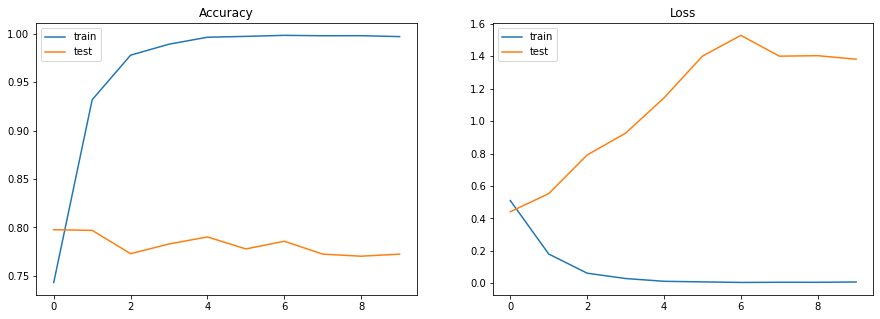

In [71]:
fig,(ax1, ax2) =  plt.subplots(1,2,figsize=(15,5))
ax1.set_title("Accuracy")
ax1.plot(history.history['acc'], label='train')
ax1.plot(history.history['val_acc'], label='test')
ax1.legend()

ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='train')
ax2.plot(history.history['val_loss'], label='test')
ax2.legend()
plt.show();

## GloVe Embeddings


In [36]:
max_features = 10000
maxlen = 200
embedding_size = 200
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts((data['clean_headline']))
tokenizer.document_count


26709

In [37]:
len(tokenizer.word_index)
num_words = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(data['clean_headline'])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Vocab size ",num_words)

Number of Samples: 26709
Vocab size  29657


#### Get the Glove Word Embeddings using Embedding file.

In [38]:
EMBEDDING_FILE = glove_file = project_path +'/glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

In [39]:
num_words

29657

#### Create a weight matrix for words in training docs

In [40]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(29657, 200)

### Splitting the data into train and test

In [41]:
X_train,X_test,Y_train,Y_test = train_test_split(X,data['is_sarcastic'], test_size = 0.2 , random_state = 0)

## Create and Compile your Model  


In [42]:
model = Sequential()
model.add(Embedding(num_words,embedding_size,weights=[embedding_matrix],input_length=maxlen,trainable=True))
model.add(Bidirectional(LSTM(units=128,dropout=0.5,recurrent_dropout=0.5)))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01),metrics=['accuracy'],loss='binary_crossentropy')

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          5931400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 6,268,553
Trainable params: 6,268,553
Non-trainable params: 0
_________________________________________________________________


## Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy


In [44]:
batch_size = 100
epochs = 5
history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Epoch 1/5
171/171 [==============================] - 268s 2s/step - loss: 0.4310 - accuracy: 0.7943 - val_loss: 0.3168 - val_accuracy: 0.8627
Epoch 2/5
171/171 [==============================] - 262s 2s/step - loss: 0.2077 - accuracy: 0.9187 - val_loss: 0.3232 - val_accuracy: 0.8645
Epoch 3/5
171/171 [==============================] - 258s 2s/step - loss: 0.1108 - accuracy: 0.9579 - val_loss: 0.4288 - val_accuracy: 0.8582
Epoch 4/5
171/171 [==============================] - 254s 1s/step - loss: 0.0643 - accuracy: 0.9757 - val_loss: 0.5948 - val_accuracy: 0.8563
Epoch 5/5
171/171 [==============================] - 254s 1s/step - loss: 0.0422 - accuracy: 0.9857 - val_loss: 0.6893 - val_accuracy: 0.8568


In [45]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100)

167/167 [==============================] - 18s 106ms/step - loss: 0.6894 - accuracy: 0.8525
Accuracy of the model on Testing Data is -  85.2489709854126


In [46]:
predictions = model.predict_classes(X_test)
predictions[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       [0],
       [1]], dtype=int32)

In [47]:
cm = confusion_matrix(Y_test,predictions)
cm

array([[2657,  350],
       [ 438, 1897]])

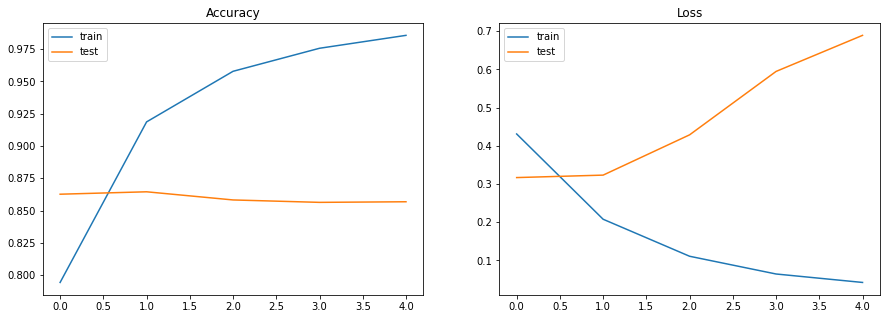

In [50]:
fig,(ax1, ax2) =  plt.subplots(1,2,figsize=(15,5))
ax1.set_title("Accuracy")
ax1.plot(history.history['accuracy'], label='train')
ax1.plot(history.history['val_accuracy'], label='test')
ax1.legend()

ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='train')
ax2.plot(history.history['val_loss'], label='test')
ax2.legend()
plt.show();